# Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

Сегодня у нас довольно объемная программа, она призвана закончить большую часть про базовую функциональность Pytorch, дальше мы двинемся к сверточным сетям и будем решать более прикладные задачи

# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

## Dataset

In [1]:
import math
import torch
import numpy as np

# from torchvision import transforms, datasets
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


In [3]:
from torchmetrics import MeanAbsolutePercentageError

In [4]:
import torch.nn.functional as F
import torch.nn as nn

In [5]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "tanh":
            return F.tanh(x)
        if self.activation == "relu":
            return F.relu(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [6]:
class CalifHousingDataset(torch.utils.data.Dataset):
   
    def __init__(self, init_features, init_target, transform=None):
        self._features_data = torch.tensor(init_features, dtype=torch.float32)
        self._target_data = torch.tensor(init_target, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self._features_data)

    def __getitem__(self, idx):
        item_features = self._features_data[idx]
        item_target = self._target_data[idx]
      
        return item_features, item_target
    
#trans_actions = transforms.Compose([transforms.ToTensor()])


In [7]:
housing_data = fetch_california_housing()

In [8]:
features, target = housing_data['data'], housing_data['target']

In [9]:
scaler_f = MinMaxScaler()

In [10]:
scaled_features = scaler_f.fit_transform(features)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.25, random_state=13)

In [12]:
x_train.shape

(15480, 8)

In [13]:
y_test.shape

(5160,)

In [14]:
dataset_train = CalifHousingDataset(x_train, y_train)

In [15]:
dataset_train[0]

(tensor([0.2081, 0.6863, 0.0262, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
 tensor(2.6800))

In [16]:
dataset_test = CalifHousingDataset(x_test, y_test)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                          batch_size=128, drop_last=True,
                          shuffle=True)

In [18]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                          batch_size=1,
                          shuffle=False)

In [19]:
net = FeedForward(8, 20)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [20]:
mean_abs_percentage_error = MeanAbsolutePercentageError()


In [21]:
num_epochs = 10
test_outputs_list = []
train_outputs_list = []


for epoch in range(num_epochs):  
    running_loss, running_items, running_mse, running_mape = 0.0, 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, targets = data[0], data[1]
        inputs = inputs.to(torch.float32)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.view(128), targets)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(targets)
        running_mse += (running_loss/running_items)
        running_mape += mean_abs_percentage_error(outputs.view(128), targets) / running_items
        
        # выводим статистику о процессе обучения
        if i % 50 == 0:    # печатаем каждые 50 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_mse:.3f}. ' \
                  f'MAPE: {running_mape:.3f}. ' , end='. ')
              
            running_loss, running_items, running_mse, running_mape = 0.0, 0.0, 0.0, 0.0

            
        if epoch==9:
            net.eval()
            nump_output = outputs.detach()
            train_outputs_list.append(nump_output.numpy())
        net.train()
            
test_running_right, test_running_total, test_running_mape = 0.0, 0.0, 0.0
net.eval()
for i, test_data in enumerate(test_loader):
                                            
    test_outputs = net(test_data[0].to(torch.float32))
    test_running_total += len(test_data[1])
    test_loss = criterion(test_outputs.view(1), test_data[1])
    test_running_right += test_loss.item()
    test_running_mape += mean_abs_percentage_error(test_outputs.view(1), test_data[1])
                
                
    nump_test_output = test_outputs.detach()
    test_outputs_list.append(nump_test_output.numpy())
            
    print(f'Test acc: {test_running_right / test_running_total:.3f}. ' \
          f'Test MAPE: {test_running_mape  / test_running_total:.3f}. ' , end='\n ')
        
        
print('Training is finished!')

Epoch [1/10]. Step [1/120]. Loss: 0.040. MAPE: 0.007. . Epoch [1/10]. Step [51/120]. Loss: 1.035. MAPE: 0.025. . Epoch [1/10]. Step [101/120]. Loss: 0.271. MAPE: 0.014. . Epoch [2/10]. Step [1/120]. Loss: 0.004. MAPE: 0.003. . Epoch [2/10]. Step [51/120]. Loss: 0.234. MAPE: 0.013. . Epoch [2/10]. Step [101/120]. Loss: 0.229. MAPE: 0.012. . Epoch [3/10]. Step [1/120]. Loss: 0.004. MAPE: 0.003. . Epoch [3/10]. Step [51/120]. Loss: 0.216. MAPE: 0.012. . Epoch [3/10]. Step [101/120]. Loss: 0.226. MAPE: 0.012. . Epoch [4/10]. Step [1/120]. Loss: 0.004. MAPE: 0.003. . Epoch [4/10]. Step [51/120]. Loss: 0.217. MAPE: 0.012. . Epoch [4/10]. Step [101/120]. Loss: 0.225. MAPE: 0.013. . Epoch [5/10]. Step [1/120]. Loss: 0.006. MAPE: 0.003. . Epoch [5/10]. Step [51/120]. Loss: 0.228. MAPE: 0.013. . Epoch [5/10]. Step [101/120]. Loss: 0.213. MAPE: 0.011. . Epoch [6/10]. Step [1/120]. Loss: 0.005. MAPE: 0.003. . Epoch [6/10]. Step [51/120]. Loss: 0.219. MAPE: 0.012. . Epoch [6/10]. Step [101/120]. Lo

 Test acc: 0.613. Test MAPE: 0.270. 
 Test acc: 0.612. Test MAPE: 0.269. 
 Test acc: 0.611. Test MAPE: 0.269. 
 Test acc: 0.626. Test MAPE: 0.270. 
 Test acc: 0.628. Test MAPE: 0.270. 
 Test acc: 0.628. Test MAPE: 0.270. 
 Test acc: 0.627. Test MAPE: 0.270. 
 Test acc: 0.628. Test MAPE: 0.270. 
 Test acc: 0.628. Test MAPE: 0.271. 
 Test acc: 0.628. Test MAPE: 0.271. 
 Test acc: 0.651. Test MAPE: 0.272. 
 Test acc: 0.650. Test MAPE: 0.272. 
 Test acc: 0.649. Test MAPE: 0.272. 
 Test acc: 0.648. Test MAPE: 0.272. 
 Test acc: 0.647. Test MAPE: 0.271. 
 Test acc: 0.645. Test MAPE: 0.271. 
 Test acc: 0.646. Test MAPE: 0.271. 
 Test acc: 0.650. Test MAPE: 0.271. 
 Test acc: 0.649. Test MAPE: 0.271. 
 Test acc: 0.648. Test MAPE: 0.271. 
 Test acc: 0.646. Test MAPE: 0.271. 
 Test acc: 0.645. Test MAPE: 0.271. 
 Test acc: 0.645. Test MAPE: 0.271. 
 Test acc: 0.644. Test MAPE: 0.270. 
 Test acc: 0.642. Test MAPE: 0.270. 
 Test acc: 0.641. Test MAPE: 0.270. 
 Test acc: 0.640. Test MAPE: 0.270. 
 

 Test acc: 0.622. Test MAPE: 0.292. 
 Test acc: 0.621. Test MAPE: 0.292. 
 Test acc: 0.624. Test MAPE: 0.293. 
 Test acc: 0.624. Test MAPE: 0.293. 
 Test acc: 0.624. Test MAPE: 0.293. 
 Test acc: 0.626. Test MAPE: 0.293. 
 Test acc: 0.625. Test MAPE: 0.293. 
 Test acc: 0.625. Test MAPE: 0.292. 
 Test acc: 0.624. Test MAPE: 0.292. 
 Test acc: 0.623. Test MAPE: 0.292. 
 Test acc: 0.623. Test MAPE: 0.292. 
 Test acc: 0.622. Test MAPE: 0.292. 
 Test acc: 0.621. Test MAPE: 0.291. 
 Test acc: 0.622. Test MAPE: 0.291. 
 Test acc: 0.622. Test MAPE: 0.291. 
 Test acc: 0.621. Test MAPE: 0.291. 
 Test acc: 0.620. Test MAPE: 0.291. 
 Test acc: 0.620. Test MAPE: 0.291. 
 Test acc: 0.619. Test MAPE: 0.291. 
 Test acc: 0.619. Test MAPE: 0.290. 
 Test acc: 0.618. Test MAPE: 0.290. 
 Test acc: 0.617. Test MAPE: 0.290. 
 Test acc: 0.617. Test MAPE: 0.290. 
 Test acc: 0.616. Test MAPE: 0.290. 
 Test acc: 0.615. Test MAPE: 0.289. 
 Test acc: 0.614. Test MAPE: 0.289. 
 Test acc: 0.614. Test MAPE: 0.289. 
 

 Test acc: 0.579. Test MAPE: 0.279. 
 Test acc: 0.578. Test MAPE: 0.278. 
 Test acc: 0.578. Test MAPE: 0.278. 
 Test acc: 0.577. Test MAPE: 0.278. 
 Test acc: 0.577. Test MAPE: 0.278. 
 Test acc: 0.579. Test MAPE: 0.278. 
 Test acc: 0.578. Test MAPE: 0.278. 
 Test acc: 0.579. Test MAPE: 0.278. 
 Test acc: 0.579. Test MAPE: 0.278. 
 Test acc: 0.580. Test MAPE: 0.278. 
 Test acc: 0.580. Test MAPE: 0.278. 
 Test acc: 0.583. Test MAPE: 0.278. 
 Test acc: 0.583. Test MAPE: 0.278. 
 Test acc: 0.583. Test MAPE: 0.278. 
 Test acc: 0.582. Test MAPE: 0.278. 
 Test acc: 0.582. Test MAPE: 0.278. 
 Test acc: 0.587. Test MAPE: 0.279. 
 Test acc: 0.586. Test MAPE: 0.279. 
 Test acc: 0.586. Test MAPE: 0.279. 
 Test acc: 0.585. Test MAPE: 0.279. 
 Test acc: 0.585. Test MAPE: 0.279. 
 Test acc: 0.585. Test MAPE: 0.279. 
 Test acc: 0.584. Test MAPE: 0.278. 
 Test acc: 0.584. Test MAPE: 0.278. 
 Test acc: 0.583. Test MAPE: 0.278. 
 Test acc: 0.583. Test MAPE: 0.278. 
 Test acc: 0.582. Test MAPE: 0.278. 
 

 Test acc: 0.592. Test MAPE: 0.273. 
 Test acc: 0.593. Test MAPE: 0.273. 
 Test acc: 0.600. Test MAPE: 0.274. 
 Test acc: 0.600. Test MAPE: 0.274. 
 Test acc: 0.600. Test MAPE: 0.274. 
 Test acc: 0.599. Test MAPE: 0.274. 
 Test acc: 0.599. Test MAPE: 0.274. 
 Test acc: 0.599. Test MAPE: 0.273. 
 Test acc: 0.598. Test MAPE: 0.273. 
 Test acc: 0.598. Test MAPE: 0.273. 
 Test acc: 0.597. Test MAPE: 0.273. 
 Test acc: 0.597. Test MAPE: 0.273. 
 Test acc: 0.596. Test MAPE: 0.273. 
 Test acc: 0.596. Test MAPE: 0.273. 
 Test acc: 0.595. Test MAPE: 0.273. 
 Test acc: 0.595. Test MAPE: 0.273. 
 Test acc: 0.595. Test MAPE: 0.273. 
 Test acc: 0.594. Test MAPE: 0.273. 
 Test acc: 0.594. Test MAPE: 0.273. 
 Test acc: 0.594. Test MAPE: 0.272. 
 Test acc: 0.593. Test MAPE: 0.272. 
 Test acc: 0.593. Test MAPE: 0.272. 
 Test acc: 0.593. Test MAPE: 0.272. 
 Test acc: 0.594. Test MAPE: 0.273. 
 Test acc: 0.594. Test MAPE: 0.273. 
 Test acc: 0.594. Test MAPE: 0.273. 
 Test acc: 0.593. Test MAPE: 0.272. 
 

 Test acc: 0.579. Test MAPE: 0.268. 
 Test acc: 0.579. Test MAPE: 0.268. 
 Test acc: 0.579. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.580. Test MAPE: 0.268. 
 Test acc: 0.580. Test MAPE: 0.268. 
 Test acc: 0.580. Test MAPE: 0.268. 
 Test acc: 0.580. Test MAPE: 0.268. 
 Test acc: 0.580. Test MAPE: 0.268. 
 Test acc: 0.582. Test MAPE: 0.269. 
 Test acc: 0.582. Test MAPE: 0.269. 
 Test acc: 0.582. Test MAPE: 0.269. 
 Test acc: 0.582. Test MAPE: 0.271. 
 Test acc: 0.582. Test MAPE: 0.271. 
 Test acc: 0.582. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 Test acc: 0.581. Test MAPE: 0.270. 
 

 Test acc: 0.599. Test MAPE: 0.273. 
 Test acc: 0.599. Test MAPE: 0.273. 
 Test acc: 0.599. Test MAPE: 0.273. 
 Test acc: 0.598. Test MAPE: 0.273. 
 Test acc: 0.598. Test MAPE: 0.273. 
 Test acc: 0.599. Test MAPE: 0.273. 
 Test acc: 0.599. Test MAPE: 0.272. 
 Test acc: 0.598. Test MAPE: 0.272. 
 Test acc: 0.599. Test MAPE: 0.272. 
 Test acc: 0.598. Test MAPE: 0.272. 
 Test acc: 0.598. Test MAPE: 0.272. 
 Test acc: 0.598. Test MAPE: 0.272. 
 Test acc: 0.597. Test MAPE: 0.272. 
 Test acc: 0.597. Test MAPE: 0.272. 
 Test acc: 0.597. Test MAPE: 0.272. 
 Test acc: 0.597. Test MAPE: 0.272. 
 Test acc: 0.597. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.596. Test MAPE: 0.272. 
 Test acc: 0.595. Test MAPE: 0.272. 
 Test acc: 0.595. Test MAPE: 0.272. 
 Test acc: 0.595. Test MAPE: 0.272. 
 Test acc: 0.595. Test MAPE: 0.272. 
 

 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.603. Test MAPE: 0.270. 
 Test acc: 0.602. Test MAPE: 0.270. 
 Test acc: 0.602. Test MAPE: 0.270. 
 Test acc: 0.602. Test MAPE: 0.270. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.603. Test MAPE: 0.269. 
 Test acc: 0.603. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.602. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 Test acc: 0.601. Test MAPE: 0.269. 
 

 Test acc: 0.595. Test MAPE: 0.270. 
 Test acc: 0.595. Test MAPE: 0.270. 
 Test acc: 0.594. Test MAPE: 0.270. 
 Test acc: 0.594. Test MAPE: 0.270. 
 Test acc: 0.594. Test MAPE: 0.270. 
 Test acc: 0.594. Test MAPE: 0.269. 
 Test acc: 0.594. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.593. Test MAPE: 0.269. 
 Test acc: 0.596. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.594. Test MAPE: 0.269. 
 Test acc: 0.596. Test MAPE: 0.269. 
 Test acc: 0.596. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.595. Test MAPE: 0.269. 
 Test acc: 0.596. Test MAPE: 0.269. 
 

 Test acc: 0.589. Test MAPE: 0.265. 
 Test acc: 0.589. Test MAPE: 0.265. 
 Test acc: 0.590. Test MAPE: 0.265. 
 Test acc: 0.591. Test MAPE: 0.266. 
 Test acc: 0.591. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.593. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.594. Test MAPE: 0.266. 
 Test acc: 0.595. Test MAPE: 0.266. 
 Test acc: 0.595. Test MAPE: 0.266. 
 

 Test acc: 0.584. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.584. Test MAPE: 0.267. 
 Test acc: 0.585. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.268. 
 Test acc: 0.586. Test MAPE: 0.268. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.268. 
 Test acc: 0.585. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.268. 
 Test acc: 0.588. Test MAPE: 0.268. 
 Test acc: 0.588. Test MAPE: 0.268. 
 Test acc: 0.588. Test MAPE: 0.268. 
 Test acc: 0.588. Test MAPE: 0.268. 
 Test acc: 0.588. Test MAPE: 0.268. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.268. 
 Test acc: 0.587. Test MAPE: 0.268. 
 Test acc: 0.587. Test MAPE: 0.268. 
 Test acc: 0.587. Test MAPE: 0.267. 
 

 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.576. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.577. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 

 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.583. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.586. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.588. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 Test acc: 0.587. Test MAPE: 0.267. 
 

 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.578. Test MAPE: 0.266. 
 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.577. Test MAPE: 0.266. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.266. 
 Test acc: 0.580. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.578. Test MAPE: 0.267. 
 

 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.578. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.577. Test MAPE: 0.268. 
 Test acc: 0.576. Test MAPE: 0.268. 
 Test acc: 0.576. Test MAPE: 0.268. 
 

 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 Test acc: 0.579. Test MAPE: 0.267. 
 

 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.582. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.581. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 Test acc: 0.580. Test MAPE: 0.267. 
 

 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.577. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.578. Test MAPE: 0.265. 
 Test acc: 0.579. Test MAPE: 0.266. 
 Test acc: 0.579. Test MAPE: 0.265. 
 Test acc: 0.579. Test MAPE: 0.265. 
 Test acc: 0.579. Test MAPE: 0.266. 
 

In [42]:
y_train[:100]

array([2.68   , 1.902  , 1.375  , 1.488  , 1.413  , 2.145  , 1.375  ,
       1.668  , 3.356  , 2.346  , 4.186  , 2.26   , 5.00001, 0.854  ,
       0.746  , 2.802  , 3.969  , 5.00001, 0.902  , 1.198  , 5.00001,
       2.424  , 0.906  , 0.934  , 3.368  , 2.503  , 1.846  , 2.201  ,
       0.561  , 1.674  , 0.706  , 2.67   , 0.764  , 1.234  , 1.339  ,
       1.202  , 1.734  , 0.869  , 3.614  , 0.62   , 1.642  , 1.375  ,
       2.933  , 2.21   , 1.632  , 0.882  , 2.444  , 1.73   , 0.929  ,
       2.365  , 5.00001, 1.675  , 1.984  , 0.591  , 2.675  , 2.177  ,
       5.00001, 0.802  , 1.136  , 2.304  , 2.75   , 2.11   , 2.536  ,
       3.13   , 1.328  , 2.431  , 3.5    , 3.674  , 2.553  , 1.233  ,
       2.596  , 0.773  , 2.954  , 0.552  , 4.5    , 1.464  , 2.854  ,
       2.051  , 1.739  , 1.85   , 1.1    , 0.868  , 1.612  , 1.744  ,
       3.238  , 2.451  , 1.402  , 3.058  , 1.024  , 1.036  , 1.13   ,
       1.347  , 1.917  , 1.125  , 1.188  , 1.875  , 5.00001, 1.588  ,
       1.563  , 4.1 

In [27]:
test_preds = np.array(test_outputs_list).flatten()

In [29]:
train_preds = np.array(train_outputs_list).flatten()

In [31]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

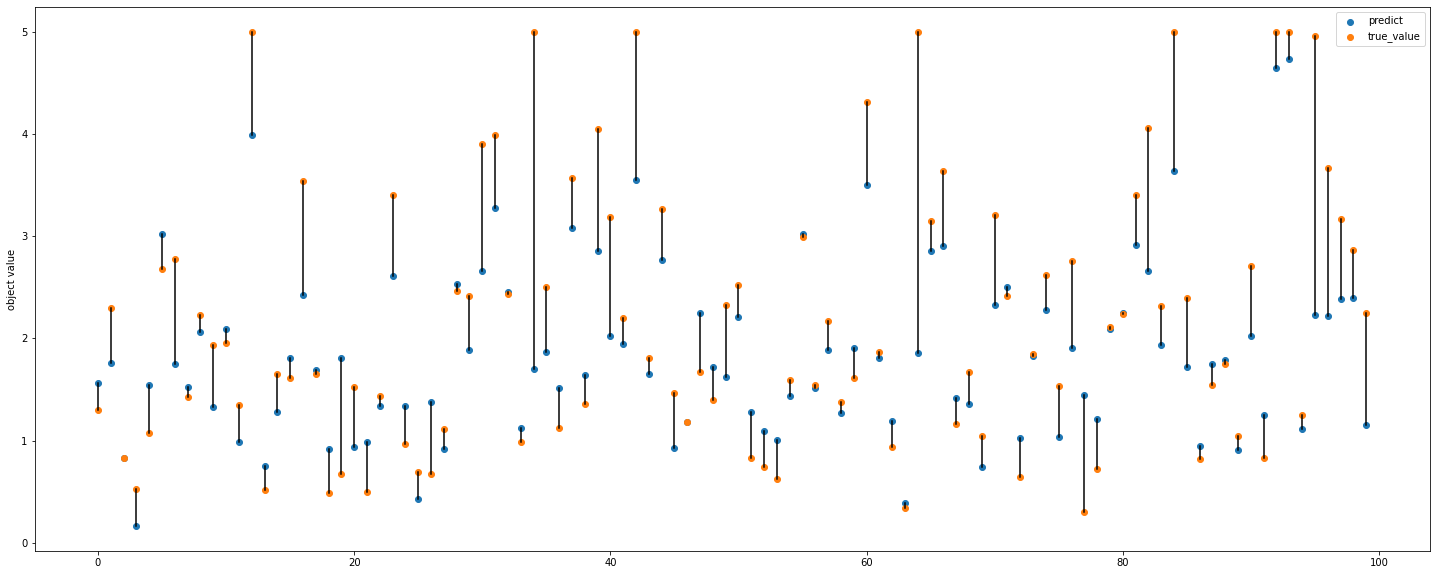

In [45]:
x = np.arange(100)
plt.figure(figsize=(25,10))
plt.plot((x,x),(test_preds[:100], y_test[:100]),c='black')
plt.scatter(x, test_preds[:100], label='predict')
plt.scatter(x, y_test[:100], label='true_value')
plt.ylabel('object value')
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

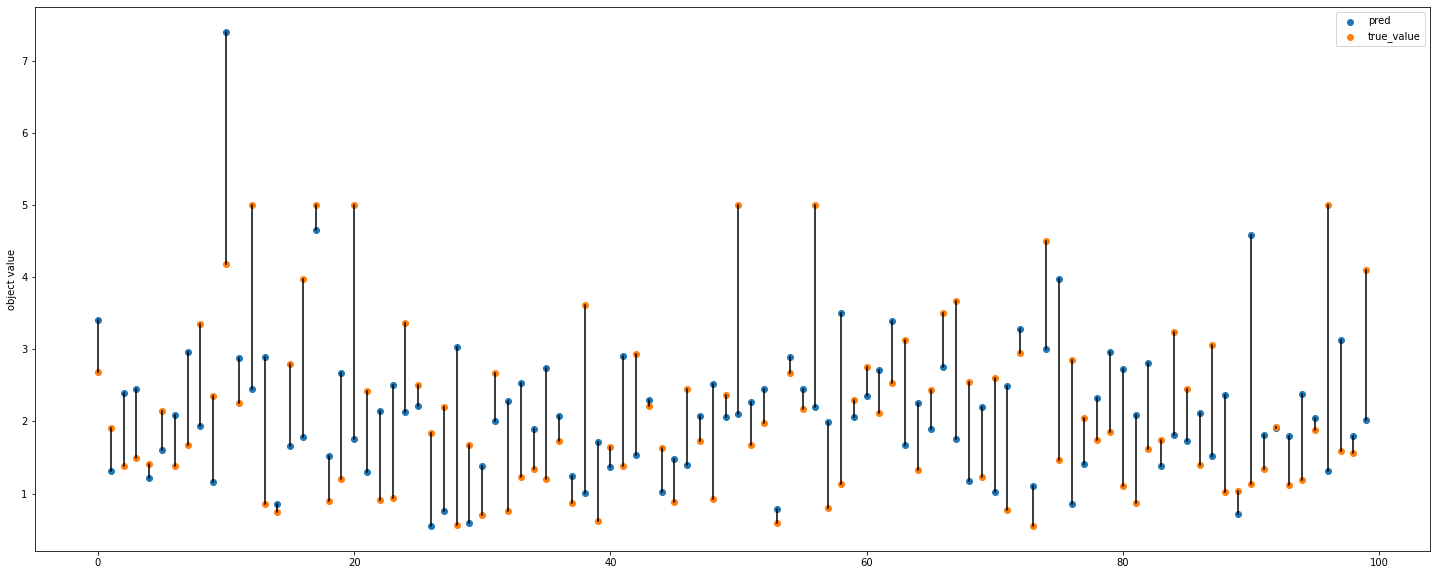

In [47]:
x = np.arange(100)
plt.figure(figsize=(25,10))
plt.plot((x,x),(train_preds[:100], y_train[:100]),c='black')
plt.scatter(x, train_preds[:100], label='pred')
plt.scatter(x, y_train[:100], label='true_value')
plt.ylabel('object value')
plt.legend()
plt.show

In [ ]:
Плохо справляется с выбросами, но вцелом очень неплохо.